# CNN + FSL
- In this example we will explore the combination of using CNN layers of VGG16 and HDC for classification
- This is a conceptual replication of the work in https://arxiv.org/abs/2409.10918
- Take note that we had to pretrain a quantized VGG16 for this

# Importing Packages

In [23]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import vgg16
from torch.quantization import QuantStub, DeQuantStub
import torch.quantization
import torch.optim as optim
from torchinfo import summary
from vgg_models import QuantizableVGG16
import numpy as np
import torch.nn.functional as F
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm

# Importing the Model
- The model can be changed but for this experiment I had to use this one I pretrained before

In [3]:
# Load model
model = QuantizableVGG16(num_classes=100)

# Prepare for quantized loading
model.eval()  # Important for quantization
model.fuse_model()
model.qconfig = torch.quantization.get_default_qconfig("fbgemm")
torch.quantization.prepare(model, inplace=True)
torch.quantization.convert(model, inplace=True)

# Wrap in DataParallel to match saved state dict
model = torch.nn.DataParallel(model)

/users/micas/rantonio/anaconda3/envs/torchx/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/users/micas/rantonio/anaconda3/envs/torchx/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/users/micas/rantonio/anaconda3/envs/torchx/lib/python3.10/site-packages/torch/ao/quantization/observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
/users/micas/rantoni

The loading below should say that all keys match. If not, consider making sure your models match.

In [4]:
# Load quantized state_dict
state_dict = torch.load("quantized_vgg16_cifar100.pth", map_location='cpu')
model.load_state_dict(state_dict)

/users/micas/rantonio/anaconda3/envs/torchx/lib/python3.10/site-packages/torch/_utils.py:431: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  device=storage.device,


<All keys matched successfully>

In [5]:
quantized_model = torch.quantization.convert(model, inplace=False)
quantized_model = quantized_model.module  # unwrap from DataParallel
quantized_model.eval()
quantized_model.to('cpu');

# Function Hook
- This is used to extract the output done on the final max-pool layer of the CNN block

In [6]:
# Placeholder for feature map
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Register hook at the desired layer (e.g., layer 30)
layer_index = 30  # verify this with print(model.features)
quantized_model.features[layer_index].register_forward_hook(get_activation('last_maxpool'))


# Download CIFAR-100 Dataset

In [7]:
transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4865, 0.4409],
                         std=[0.2673, 0.2564, 0.2762])
])

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                        download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=4)

# Some Useful Functions
- `get_n_samples_per_class`: Used to get n samples per class.
- `project_qhv`: Used to project a CNN feature vector into a query HV. It is already signed at the end.
- `sim_search`: Used to do similarity search and return the similarity score and target label value.

In [8]:
def get_n_samples_per_class(dataset, N):
    class_samples = defaultdict(list)
    class_counts = defaultdict(int)

    num_classes = len(dataset.classes)

    # tqdm wraps the iterable to show progress
    for sample, label in tqdm(dataset, desc="Collecting samples"):
        if class_counts[label] < N:
            class_samples[label].append((sample, label))
            class_counts[label] += 1

        # Stop early if we have enough samples for all classes
        if all(class_counts[c] >= N for c in range(num_classes)):
            break

    return dict(class_samples)

In [9]:
def project_qhv(query_v, projection_matrix):
    # First pass through the model the samples
    # Class, item #, tensor is at [0]
    output = quantized_model(query_v)
    # Get the output
    intermediate_output = activation['last_maxpool']
    # Get the values and put to float first
    int_values = intermediate_output.int_repr().float()
    # Flatten
    flattened = int_values.reshape(1, -1)  # shape: [1, 25088]
    # Do random projection
    projected = flattened @ projection_matrix  # shape: [1, 512]
    return projected

In [10]:
def sim_search(class_hvs, q_hv):
    sim_score = -2
    target_label = -9
    for i in range(len(class_hvs)):
        cos_sim  = F.cosine_similarity(q_hv, class_hvs[i], dim=1)
        if cos_sim > sim_score:
            sim_score = cos_sim
            target_label = i
    return sim_score, target_label

# Get Samples

In [11]:
MAX_SAMPLES = 100
samples_per_class = get_n_samples_per_class(testset, MAX_SAMPLES)

In [12]:
# Check how many samples collected for class 0 and 1
print(f"Class 0 samples: {len(samples_per_class[0])}")
print(f"Class 1 samples: {len(samples_per_class[1])}")
print(f"Class 99 samples: {len(samples_per_class[99])}")

Class 0 samples: 100
Class 1 samples: 100
Class 99 samples: 100


In [13]:
samples_per_class[0][0][0].unsqueeze(0).shape

torch.Size([1, 3, 224, 224])

# Make Projection Matrix

In [14]:
# Set the dimensions
input_dim = 25088   # e.g., 512 channels × 7 × 7
output_dim = 512    # your projected size

# Randomly generate +1 and -1 entries
projection_matrix = (torch.randint(0, 2, (input_dim, output_dim)) * 2 - 1).float()  # values: [0, 1] → [−1, 1]
projection_matrix.shape

torch.Size([25088, 512])

# HDC Training

In [15]:
# Some fixed parameters
NUM_CLASSES = 100
HV_DIM = 512
NUM_TRAIN_SAMPLES = 50

# Initialize class HVs
class_hvs_bin = {}
class_hvs_int = {}

# Iterate per class with tqdm
for class_set in tqdm(range(NUM_CLASSES), desc="Processing classes"):

    # Initialize class hv
    class_hv = torch.zeros(HV_DIM)

    for item in range(NUM_TRAIN_SAMPLES):
        query_v = samples_per_class[class_set][item][0].unsqueeze(0)
        projected = project_qhv(query_v, projection_matrix)
        class_hv = class_hv + projected

    label = samples_per_class[class_set][0][1]
    class_hvs_int[label] = class_hv

    # Sign magnitude
    class_hv_bin = torch.sign(class_hv)
    class_hvs_bin[label] = class_hv_bin
    

Processing classes: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:10<00:00,  3.10s/it]


# HDC Classification

In [29]:
START_NUM = NUM_TRAIN_SAMPLES
MAX_SAMPLES = 100

correct_qhv_int = 0
correct_qhv_bin = 0

for class_set in tqdm(range(NUM_CLASSES), desc="Evaluating classes"):  
    for item in range(NUM_TRAIN_SAMPLES):
        projected = project_qhv(samples_per_class[class_set][item][0].unsqueeze(0), projection_matrix)
        # Compare int style first
        _, target_label_int = sim_search(class_hvs_int, projected)
        # Compare bin style 2nd
        projected_bin = torch.sign(projected)
        _, target_label_bin = sim_search(class_hvs_bin, projected_bin)

        if target_label_int == class_set:
            correct_qhv_int += 1

        if target_label_bin == class_set:
            correct_qhv_bin += 1


Evaluating classes: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:51<00:00,  3.51s/it]


In [30]:
TOTAL_TEST = (NUM_TRAIN_SAMPLES)*NUM_CLASSES
accuracy_int = correct_qhv_int / TOTAL_TEST
accuracy_bin = correct_qhv_bin / TOTAL_TEST
print(f"Accuracy (int): {accuracy_int:.2f}")
print(f"Accuracy (bin): {accuracy_bin:.2f}")

Accuracy (int): 0.81
Accuracy (bin): 0.58


In [31]:
START_NUM = NUM_TRAIN_SAMPLES
MAX_SAMPLES = 100

correct_qhv_int = 0
correct_qhv_bin = 0

for class_set in tqdm(range(NUM_CLASSES), desc="Evaluating classes"):  
    for item in range(START_NUM, MAX_SAMPLES):
        projected = project_qhv(samples_per_class[class_set][item][0].unsqueeze(0), projection_matrix)
        # Compare int style first
        _, target_label_int = sim_search(class_hvs_int, projected)
        # Compare bin style 2nd
        projected_bin = torch.sign(projected)
        _, target_label_bin = sim_search(class_hvs_bin, projected_bin)

        if target_label_int == class_set:
            correct_qhv_int += 1

        if target_label_bin == class_set:
            correct_qhv_bin += 1

Evaluating classes: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:55<00:00,  3.56s/it]


In [32]:
TOTAL_TEST = (MAX_SAMPLES - NUM_TRAIN_SAMPLES)*NUM_CLASSES
accuracy_int = correct_qhv_int / TOTAL_TEST
accuracy_bin = correct_qhv_bin / TOTAL_TEST
print(f"Accuracy (int): {accuracy_int:.2f}")
print(f"Accuracy (bin): {accuracy_bin:.2f}")

Accuracy (int): 0.49
Accuracy (bin): 0.33


# Inter-class Similarity for Integer HVs

In [42]:
inter_class_sim_int = np.zeros((100, 100))

for i in tqdm(range(100), desc="Evaluating classes"):
    for j in range(100):
        cos_sim  = F.cosine_similarity(class_hvs_int[i][0], class_hvs_int[j][0], dim=0)
        inter_class_sim_int[i][j] = cos_sim

Evaluating classes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 245.71it/s]


In [43]:
min_score = inter_class_sim_int.min().min()
max_score = inter_class_sim_int.max().max()
print(f"Min score: {min_score}")
print(f"Max score: {max_score}")

Min score: 0.06309647858142853
Max score: 1.0000001192092896


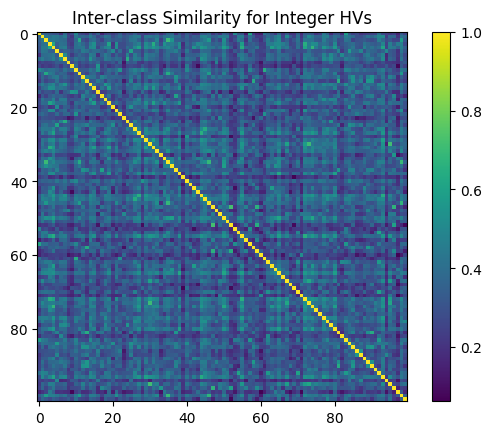

In [49]:
plt.imshow(inter_class_sim_int, cmap='viridis', interpolation='nearest')
plt.colorbar()  # Show color scale
plt.title("Inter-class Similarity for Integer HVs")
plt.show()

# Inter-class Similarity for Binary HVs

In [45]:
inter_class_sim_bin = np.zeros((100, 100))

for i in tqdm(range(100), desc="Evaluating classes"):
    for j in range(100):
        cos_sim  = F.cosine_similarity(class_hvs_bin[i][0], class_hvs_bin[j][0], dim=0)
        inter_class_sim_bin[i][j] = cos_sim

Evaluating classes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 282.32it/s]


In [47]:
min_score = inter_class_sim_bin.min().min()
max_score = inter_class_sim_bin.max().max()
print(f"Min score: {min_score}")
print(f"Max score: {max_score}")

Min score: -0.0195312462747097
Max score: 1.0000001192092896


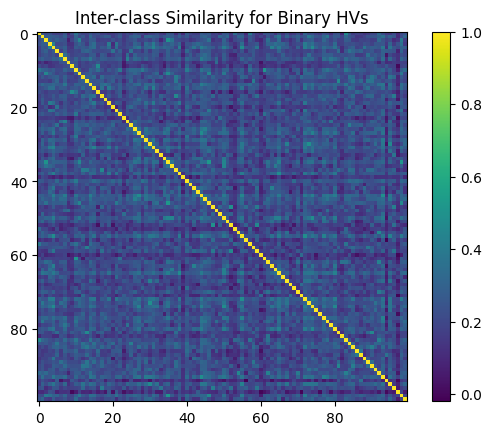

In [48]:
plt.imshow(inter_class_sim_bin, cmap='viridis', interpolation='nearest')
plt.colorbar()  # Show color scale
plt.title("Inter-class Similarity for Binary HVs")
plt.show()

# Some Conclusions
- It appears the HDC works best only when we use integer HVs, accuracy drops drastically when you use binary only.
- The VGG is not as good as a feature extractor. It appears that the nice accuracy only works when you have a fully-connected layer to support it.
- The CNN + HDC style does not work so well when you test on unseen data. So the HDC part sort of overfits.
- Note sure if using more test data would eventually get to the averaged actual accuracy.
- The reason we use only 50 samples is only because we try to "believe" in the HDC's capability for FSL.
- Main conclusion is that we need a better feature extraction.

# Some Interesting Observations
- When you actually measure the co-simularity between the class HVs, you will see they are not "orthogonal" enough. Interclass similarity is too high!
- I think this can be rectified with a proper binary neual network after the CNN feature extraction!
- In the CNN + FSL work: https://arxiv.org/abs/2409.10918; the CIFAR 100 only reports an accuracy of 50%. That is also using integer level classification. Doing binary makes it worse.
- However, I think we can do it better if we apply binary neural network!